# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [ ]:
!pip install git+https://github.com/openai/baselines.git


In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack
from tensorflow import keras
from tensorflow.keras import layers

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
FRAME_STACK_SIZE = 3
env = gym.make("Asterix-v0")
env = NoopResetEnv(env, noop_max=30)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)
env = FrameStack(env, FRAME_STACK_SIZE)
env.seed(SEED_VALUE)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\program files\python38\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [2]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(84, 84, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


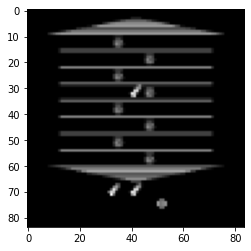

In [3]:
obs = env.reset()
from skimage.color import rgb2gray

# def preprocess_observation(observation):
#     img = observation[23:153:2, ::2] # This becomes 90, 80, 3
# #     print(img.shape)
# #     print(img.shape)
# #     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
#     img = rgb2gray(img)
#     img = img.astype(np.float32) # normalize from -128 to 127
#     return img.reshape(65, 80)


plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    # Release the global state to avoid clutter
    # when creating models (in loops etc.)
#     K.clear_session()
    
    # Reset the Tensorflow graph
#     tf.compat.v1.reset_default_graph()
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

In [5]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
MEMORY_SIZE = 25000
EXPLORATION_STEPS = 20000
LEARNING_RATE = 0.00025

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [6]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [7]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [10]:
from collections import deque
import math

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS  # speed of decay

class QLearningAgent():
    steps = 0
    
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_size)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_size)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        
        no_state = np.zeros(INPUT_SHAPE)
        
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
    
        prev_q_vals = self.online.predict(prev_states)
        
        next_q_vals_double = self.online.predict(next_states)
        next_q_vals = self.target.predict(next_states)
        
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value
            future_q_val = q_val
            
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            X[idx] = curr_state
            Y[idx] = future_q_val
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value
        """
        
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        if step <= EXPLORATION_STEPS:
            return
        
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [11]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
ep_steps = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        state = np.array(env.reset())
        total_reward = 0
#         state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_state, reward, done, info = env.step(action)

    next_state = np.array(next_state)
    
#     next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done, step)
    
    if step > EXPLORATION_STEPS:
        if step % train_online_steps == 0:
            agent.train(step)

        # Regularly copy the online DQN to the target DQN
        if step % update_target_steps == 0:
            agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 353/1000000 (0.04%)	Loss:   inf	AVG reward: 83	Total mean: 250.0
	Action step: 757/1000000 (0.08%)	Loss:   inf	AVG reward: 100	Total mean: 275.0
	Action step: 1020/1000000 (0.10%)	Loss:   inf	AVG reward: 33	Total mean: 216.66666666666666
	Action step: 1262/1000000 (0.13%)	Loss:   inf	AVG reward: 66	Total mean: 212.5
	Action step: 1599/1000000 (0.16%)	Loss:   inf	AVG reward: 116	Total mean: 240.0
	Action step: 1891/1000000 (0.19%)	Loss:   inf	AVG reward: 100	Total mean: 250.0
	Action step: 2140/1000000 (0.21%)	Loss:   inf	AVG reward: 50	Total mean: 235.71428571428572
	Action step: 2796/1000000 (0.28%)	Loss:   inf	AVG reward: 250	Total mean: 300.0
	Action step: 3088/1000000 (0.31%)	Loss:   inf	AVG reward: 50	Total mean: 283.3333333333333
	Action step: 3416/1000000 (0.34%)	Loss:   inf	AVG reward: 83	Total mean: 280.0
	Action step: 

	Action step: 30626/1000000 (3.06%)	Loss: 1.173055	AVG reward: 83	Total mean: 267.04545454545456
	Action step: 30955/1000000 (3.10%)	Loss: 0.694194	AVG reward: 100	Total mean: 267.4157303370786
	Action step: 31353/1000000 (3.14%)	Loss: 0.579855	AVG reward: 116	Total mean: 268.3333333333333
	Action step: 31890/1000000 (3.19%)	Loss: 1.164320	AVG reward: 133	Total mean: 269.7802197802198
	Action step: 32214/1000000 (3.22%)	Loss: 1.076339	AVG reward: 116	Total mean: 270.6521739130435
	Action step: 32553/1000000 (3.26%)	Loss: 0.499479	AVG reward: 66	Total mean: 269.89247311827955
	Action step: 32799/1000000 (3.28%)	Loss: 0.335590	AVG reward: 50	Total mean: 268.6170212765957
	Action step: 33129/1000000 (3.31%)	Loss: 0.535127	AVG reward: 100	Total mean: 268.94736842105266
	Action step: 33424/1000000 (3.34%)	Loss: 0.926473	AVG reward: 66	Total mean: 268.2291666666667
	Action step: 33782/1000000 (3.38%)	Loss: 0.660917	AVG reward: 133	Total mean: 269.58762886597935
	Action step: 34256/1000000 (3

	Action step: 60363/1000000 (6.04%)	Loss: 0.828076	AVG reward: 216	Total mean: 284.59302325581393
	Action step: 60925/1000000 (6.09%)	Loss: 0.466457	AVG reward: 183	Total mean: 286.1271676300578
	Action step: 61286/1000000 (6.13%)	Loss: 0.407187	AVG reward: 116	Total mean: 286.4942528735632
	Action step: 61585/1000000 (6.16%)	Loss: 0.598063	AVG reward: 116	Total mean: 286.85714285714283
	Action step: 62169/1000000 (6.22%)	Loss: 0.322610	AVG reward: 250	Total mean: 289.4886363636364
	Action step: 62593/1000000 (6.26%)	Loss: 0.403825	AVG reward: 116	Total mean: 289.8305084745763
	Action step: 62857/1000000 (6.29%)	Loss: 0.678292	AVG reward: 66	Total mean: 289.3258426966292
	Action step: 63128/1000000 (6.31%)	Loss: 0.694243	AVG reward: 83	Total mean: 289.10614525139664
	Action step: 63447/1000000 (6.34%)	Loss: 0.565815	AVG reward: 133	Total mean: 289.72222222222223
	Action step: 63836/1000000 (6.38%)	Loss: 0.380555	AVG reward: 183	Total mean: 291.16022099447514
	Action step: 64114/1000000

	Action step: 87858/1000000 (8.79%)	Loss: 0.345853	AVG reward: 100	Total mean: 279.8828125
	Action step: 88175/1000000 (8.82%)	Loss: 0.542950	AVG reward: 116	Total mean: 280.15564202334633
	Action step: 88590/1000000 (8.86%)	Loss: 0.523008	AVG reward: 133	Total mean: 280.62015503875966
	Action step: 88878/1000000 (8.89%)	Loss: 0.648022	AVG reward: 100	Total mean: 280.6949806949807
	Action step: 89676/1000000 (8.97%)	Loss: 0.525720	AVG reward: 366	Total mean: 283.84615384615387
	Action step: 90239/1000000 (9.02%)	Loss: 0.736708	AVG reward: 216	Total mean: 285.2490421455939
	Action step: 90515/1000000 (9.05%)	Loss: 1.188897	AVG reward: 50	Total mean: 284.7328244274809
	Action step: 90806/1000000 (9.08%)	Loss: 0.512886	AVG reward: 83	Total mean: 284.60076045627375
	Action step: 91149/1000000 (9.11%)	Loss: 0.763670	AVG reward: 100	Total mean: 284.65909090909093
	Action step: 91430/1000000 (9.14%)	Loss: 0.980467	AVG reward: 50	Total mean: 284.1509433962264
	Action step: 91776/1000000 (9.18%

	Action step: 116872/1000000 (11.69%)	Loss: 0.728196	AVG reward: 33	Total mean: 284.95575221238937
	Action step: 117123/1000000 (11.71%)	Loss: 0.682748	AVG reward: 100	Total mean: 285.0
	Action step: 117466/1000000 (11.75%)	Loss: 0.409455	AVG reward: 116	Total mean: 285.1906158357771
	Action step: 117892/1000000 (11.79%)	Loss: 0.468136	AVG reward: 100	Total mean: 285.233918128655
	Action step: 118247/1000000 (11.82%)	Loss: 0.576228	AVG reward: 83	Total mean: 285.13119533527697
	Action step: 118757/1000000 (11.88%)	Loss: 0.851130	AVG reward: 200	Total mean: 286.04651162790697
	Action step: 119020/1000000 (11.90%)	Loss: 0.547343	AVG reward: 66	Total mean: 285.7971014492754
	Action step: 119447/1000000 (11.94%)	Loss: 0.844510	AVG reward: 150	Total mean: 286.271676300578
	Action step: 119810/1000000 (11.98%)	Loss: 0.372709	AVG reward: 133	Total mean: 286.5994236311239
	Action step: 120069/1000000 (12.01%)	Loss: 0.991955	AVG reward: 50	Total mean: 286.2068965517241
	Action step: 120380/1000

	Action step: 144302/1000000 (14.43%)	Loss: 0.757851	AVG reward: 100	Total mean: 284.32304038004753
	Action step: 144578/1000000 (14.46%)	Loss: 0.602804	AVG reward: 83	Total mean: 284.2417061611374
	Action step: 144846/1000000 (14.48%)	Loss: 0.765600	AVG reward: 16	Total mean: 283.68794326241135
	Action step: 145221/1000000 (14.52%)	Loss: 0.633817	AVG reward: 200	Total mean: 284.4339622641509
	Action step: 145528/1000000 (14.55%)	Loss: 0.621934	AVG reward: 66	Total mean: 284.2352941176471
	Action step: 145986/1000000 (14.60%)	Loss: 0.766776	AVG reward: 166	Total mean: 284.74178403755866
	Action step: 146224/1000000 (14.62%)	Loss: 0.362384	AVG reward: 33	Total mean: 284.3091334894614
	Action step: 146570/1000000 (14.66%)	Loss: 0.908165	AVG reward: 66	Total mean: 284.1121495327103
	Action step: 146956/1000000 (14.70%)	Loss: 0.355685	AVG reward: 116	Total mean: 284.26573426573424
	Action step: 147413/1000000 (14.74%)	Loss: 0.813449	AVG reward: 250	Total mean: 285.3488372093023
	Action ste

	Action step: 171466/1000000 (17.15%)	Loss: 0.517537	AVG reward: 116	Total mean: 280.35714285714283
	Action step: 171874/1000000 (17.19%)	Loss: 0.415307	AVG reward: 133	Total mean: 280.5940594059406
	Action step: 172161/1000000 (17.22%)	Loss: 0.442670	AVG reward: 66	Total mean: 280.4347826086956
	Action step: 172402/1000000 (17.24%)	Loss: 0.723291	AVG reward: 33	Total mean: 280.07889546351083
	Action step: 172748/1000000 (17.27%)	Loss: 0.493513	AVG reward: 66	Total mean: 279.9212598425197
	Action step: 172985/1000000 (17.30%)	Loss: 0.702045	AVG reward: 50	Total mean: 279.66601178781923
	Action step: 173348/1000000 (17.33%)	Loss: 0.395220	AVG reward: 83	Total mean: 279.6078431372549
	Action step: 173668/1000000 (17.37%)	Loss: 0.653705	AVG reward: 83	Total mean: 279.5499021526419
	Action step: 174036/1000000 (17.40%)	Loss: 0.647280	AVG reward: 100	Total mean: 279.58984375
	Action step: 174334/1000000 (17.43%)	Loss: 0.724969	AVG reward: 33	Total mean: 279.2397660818713
	Action step: 17459

	Action step: 198208/1000000 (19.82%)	Loss: 0.795676	AVG reward: 50	Total mean: 279.4017094017094
	Action step: 198491/1000000 (19.85%)	Loss: 0.662237	AVG reward: 66	Total mean: 279.2662116040956
	Action step: 198829/1000000 (19.88%)	Loss: 0.485582	AVG reward: 66	Total mean: 279.13117546848383
	Action step: 199102/1000000 (19.91%)	Loss: 0.304162	AVG reward: 83	Total mean: 279.0816326530612
	Action step: 199361/1000000 (19.94%)	Loss: 0.580106	AVG reward: 50	Total mean: 278.86247877758916
	Action step: 199713/1000000 (19.97%)	Loss: 0.758653	AVG reward: 133	Total mean: 279.06779661016947
	Action step: 199959/1000000 (20.00%)	Loss: 0.587945	AVG reward: 33	Total mean: 278.76480541455163
	Action step: 200335/1000000 (20.03%)	Loss: 1.130653	AVG reward: 116	Total mean: 278.88513513513516
	Action step: 200587/1000000 (20.06%)	Loss: 0.690180	AVG reward: 33	Total mean: 278.58347386172005
	Action step: 201001/1000000 (20.10%)	Loss: 0.536905	AVG reward: 116	Total mean: 278.7037037037037
	Action ste

	Action step: 225914/1000000 (22.59%)	Loss: 0.494855	AVG reward: 66	Total mean: 282.03592814371257
	Action step: 226306/1000000 (22.63%)	Loss: 0.360460	AVG reward: 83	Total mean: 281.9880418535127
	Action step: 226566/1000000 (22.66%)	Loss: 1.038991	AVG reward: 33	Total mean: 281.7164179104478
	Action step: 226853/1000000 (22.69%)	Loss: 0.582186	AVG reward: 100	Total mean: 281.7436661698957
	Action step: 227150/1000000 (22.71%)	Loss: 0.161591	AVG reward: 66	Total mean: 281.6220238095238
	Action step: 227631/1000000 (22.76%)	Loss: 0.474884	AVG reward: 233	Total mean: 282.2436849925706
	Action step: 227875/1000000 (22.79%)	Loss: 0.922236	AVG reward: 33	Total mean: 281.973293768546
	Action step: 228139/1000000 (22.81%)	Loss: 0.745118	AVG reward: 50	Total mean: 281.77777777777777
	Action step: 228447/1000000 (22.84%)	Loss: 0.747176	AVG reward: 83	Total mean: 281.7307692307692
	Action step: 228740/1000000 (22.87%)	Loss: 0.887906	AVG reward: 150	Total mean: 281.97932053175776
	Action step: 2

	Action step: 254297/1000000 (25.43%)	Loss: 1.037645	AVG reward: 100	Total mean: 287.06666666666666
	Action step: 254568/1000000 (25.46%)	Loss: 0.753577	AVG reward: 16	Total mean: 286.7509986684421
	Action step: 254786/1000000 (25.48%)	Loss: 0.846097	AVG reward: 50	Total mean: 286.5691489361702
	Action step: 255212/1000000 (25.52%)	Loss: 1.228116	AVG reward: 116	Total mean: 286.65338645418325
	Action step: 255573/1000000 (25.56%)	Loss: 0.795856	AVG reward: 116	Total mean: 286.737400530504
	Action step: 255832/1000000 (25.58%)	Loss: 0.443253	AVG reward: 66	Total mean: 286.6225165562914
	Action step: 256333/1000000 (25.63%)	Loss: 0.706648	AVG reward: 133	Total mean: 286.7724867724868
	Action step: 256736/1000000 (25.67%)	Loss: 0.257311	AVG reward: 166	Total mean: 287.05416116248347
	Action step: 257132/1000000 (25.71%)	Loss: 0.663518	AVG reward: 66	Total mean: 286.93931398416885
	Action step: 257404/1000000 (25.74%)	Loss: 0.539377	AVG reward: 66	Total mean: 286.82476943346506
	Action ste

	Action step: 282537/1000000 (28.25%)	Loss: 0.768089	AVG reward: 116	Total mean: 290.68509615384613
	Action step: 282802/1000000 (28.28%)	Loss: 0.846010	AVG reward: 33	Total mean: 290.4561824729892
	Action step: 283299/1000000 (28.33%)	Loss: 0.702720	AVG reward: 266	Total mean: 291.0671462829736
	Action step: 283547/1000000 (28.35%)	Loss: 1.068674	AVG reward: 116	Total mean: 291.1377245508982
	Action step: 283908/1000000 (28.39%)	Loss: 0.807578	AVG reward: 83	Total mean: 291.08851674641147
	Action step: 284181/1000000 (28.42%)	Loss: 1.300066	AVG reward: 66	Total mean: 290.97968936678615
	Action step: 284510/1000000 (28.45%)	Loss: 0.473190	AVG reward: 50	Total mean: 290.8114558472554
	Action step: 284849/1000000 (28.48%)	Loss: 0.581340	AVG reward: 116	Total mean: 290.8820023837902
	Action step: 285179/1000000 (28.52%)	Loss: 1.117848	AVG reward: 133	Total mean: 291.01190476190476
	Action step: 285700/1000000 (28.57%)	Loss: 0.737370	AVG reward: 316	Total mean: 291.79548156956
	Action step

	Action step: 311128/1000000 (31.11%)	Loss: 0.702958	AVG reward: 116	Total mean: 296.88524590163934
	Action step: 311624/1000000 (31.16%)	Loss: 0.575930	AVG reward: 183	Total mean: 297.16157205240177
	Action step: 311947/1000000 (31.19%)	Loss: 0.960276	AVG reward: 100	Total mean: 297.164667393675
	Action step: 312298/1000000 (31.23%)	Loss: 0.929091	AVG reward: 100	Total mean: 297.1677559912854
	Action step: 312709/1000000 (31.27%)	Loss: 0.856765	AVG reward: 133	Total mean: 297.2796517954298
	Action step: 313102/1000000 (31.31%)	Loss: 0.573190	AVG reward: 83	Total mean: 297.2282608695652
	Action step: 313349/1000000 (31.33%)	Loss: 0.958984	AVG reward: 16	Total mean: 296.9598262757872
	Action step: 313883/1000000 (31.39%)	Loss: 0.580834	AVG reward: 166	Total mean: 297.1800433839479
	Action step: 314497/1000000 (31.45%)	Loss: 0.621759	AVG reward: 216	Total mean: 297.56229685807153
	Action step: 314767/1000000 (31.48%)	Loss: 0.719372	AVG reward: 16	Total mean: 297.2943722943723
	Action ste

	Action step: 339675/1000000 (33.97%)	Loss: 0.743875	AVG reward: 83	Total mean: 300.6012024048096
	Action step: 339997/1000000 (34.00%)	Loss: 1.488314	AVG reward: 116	Total mean: 300.6506506506507
	Action step: 340367/1000000 (34.04%)	Loss: 0.924692	AVG reward: 100	Total mean: 300.65
	Action step: 340633/1000000 (34.06%)	Loss: 0.956028	AVG reward: 83	Total mean: 300.5994005994006
	Action step: 340899/1000000 (34.09%)	Loss: 0.775611	AVG reward: 100	Total mean: 300.5988023952096
	Action step: 341144/1000000 (34.11%)	Loss: 0.643802	AVG reward: 0	Total mean: 300.5988023952096
	Action step: 341391/1000000 (34.14%)	Loss: 0.779870	AVG reward: 100	Total mean: 300.59820538384844
	Action step: 341658/1000000 (34.17%)	Loss: 0.467362	AVG reward: 66	Total mean: 300.49800796812747
	Action step: 342007/1000000 (34.20%)	Loss: 0.992817	AVG reward: 116	Total mean: 300.547263681592
	Action step: 342458/1000000 (34.25%)	Loss: 0.487897	AVG reward: 216	Total mean: 300.89463220675947
	Action step: 342814/100

	Action step: 368520/1000000 (36.85%)	Loss: 0.743825	AVG reward: 150	Total mean: 305.18518518518516
	Action step: 368931/1000000 (36.89%)	Loss: 0.788367	AVG reward: 166	Total mean: 305.36540240518036
	Action step: 369459/1000000 (36.95%)	Loss: 0.679661	AVG reward: 183	Total mean: 305.59149722735674
	Action step: 369753/1000000 (36.98%)	Loss: 0.719894	AVG reward: 133	Total mean: 305.6786703601108
	Action step: 370138/1000000 (37.01%)	Loss: 0.607914	AVG reward: 116	Total mean: 305.71955719557195
	Action step: 370546/1000000 (37.05%)	Loss: 0.757145	AVG reward: 133	Total mean: 305.80645161290323
	Action step: 370860/1000000 (37.09%)	Loss: 1.068784	AVG reward: 100	Total mean: 305.8011049723757
	Action step: 371157/1000000 (37.12%)	Loss: 1.140258	AVG reward: 133	Total mean: 305.8877644894204
	Action step: 371410/1000000 (37.14%)	Loss: 0.701863	AVG reward: 66	Total mean: 305.7904411764706
	Action step: 371764/1000000 (37.18%)	Loss: 0.267999	AVG reward: 116	Total mean: 305.83103764921947
	Acti

	Action step: 396965/1000000 (39.70%)	Loss: 0.963149	AVG reward: 133	Total mean: 309.48275862068965
	Action step: 397288/1000000 (39.73%)	Loss: 1.369938	AVG reward: 116	Total mean: 309.5176571920758
	Action step: 397771/1000000 (39.78%)	Loss: 0.641752	AVG reward: 216	Total mean: 309.8106712564544
	Action step: 398047/1000000 (39.80%)	Loss: 0.842612	AVG reward: 150	Total mean: 309.9312123817713
	Action step: 398288/1000000 (39.83%)	Loss: 0.509574	AVG reward: 0	Total mean: 309.9312123817713
	Action step: 398522/1000000 (39.85%)	Loss: 0.695777	AVG reward: 0	Total mean: 309.9312123817713
	Action step: 398754/1000000 (39.88%)	Loss: 0.615904	AVG reward: 100	Total mean: 309.9226804123711
	Action step: 399091/1000000 (39.91%)	Loss: 0.871068	AVG reward: 83	Total mean: 309.87124463519314
	Action step: 399512/1000000 (39.95%)	Loss: 0.724933	AVG reward: 166	Total mean: 310.0343053173242
	Action step: 399796/1000000 (39.98%)	Loss: 0.354047	AVG reward: 66	Total mean: 309.9400171379606
	Action step: 

	Action step: 425308/1000000 (42.53%)	Loss: 0.937532	AVG reward: 133	Total mean: 313.991935483871
	Action step: 425535/1000000 (42.55%)	Loss: 0.371201	AVG reward: 33	Total mean: 313.81950040290087
	Action step: 425914/1000000 (42.59%)	Loss: 0.716530	AVG reward: 116	Total mean: 313.84863123993557
	Action step: 426239/1000000 (42.62%)	Loss: 0.504946	AVG reward: 66	Total mean: 313.75703942075626
	Action step: 426528/1000000 (42.65%)	Loss: 0.299588	AVG reward: 100	Total mean: 313.7459807073955
	Action step: 426769/1000000 (42.68%)	Loss: 0.745520	AVG reward: 50	Total mean: 313.6144578313253
	Action step: 427061/1000000 (42.71%)	Loss: 0.418218	AVG reward: 100	Total mean: 313.6035313001605
	Action step: 427322/1000000 (42.73%)	Loss: 0.468106	AVG reward: 16	Total mean: 313.39214113873294
	Action step: 427537/1000000 (42.75%)	Loss: 0.404417	AVG reward: 50	Total mean: 313.26121794871796
	Action step: 427810/1000000 (42.78%)	Loss: 0.881768	AVG reward: 100	Total mean: 313.2506004803843
	Action ste

	Action step: 452702/1000000 (45.27%)	Loss: 0.559422	AVG reward: 100	Total mean: 316.47727272727275
	Action step: 453058/1000000 (45.31%)	Loss: 0.559463	AVG reward: 183	Total mean: 316.6540499621499
	Action step: 453512/1000000 (45.35%)	Loss: 0.692164	AVG reward: 166	Total mean: 316.7927382753404
	Action step: 453773/1000000 (45.38%)	Loss: 0.599786	AVG reward: 100	Total mean: 316.7800453514739
	Action step: 454050/1000000 (45.41%)	Loss: 0.882697	AVG reward: 133	Total mean: 316.8429003021148
	Action step: 454345/1000000 (45.43%)	Loss: 0.632619	AVG reward: 166	Total mean: 316.9811320754717
	Action step: 454772/1000000 (45.48%)	Loss: 0.899505	AVG reward: 150	Total mean: 317.0814479638009
	Action step: 455010/1000000 (45.50%)	Loss: 0.741198	AVG reward: 0	Total mean: 317.0814479638009
	Action step: 455380/1000000 (45.54%)	Loss: 0.805530	AVG reward: 133	Total mean: 317.1439336850038
	Action step: 455624/1000000 (45.56%)	Loss: 0.662466	AVG reward: 50	Total mean: 317.01807228915663
	Action ste

	Action step: 478179/1000000 (47.82%)	Loss: 0.805777	AVG reward: 16	Total mean: 316.89285714285717
	Action step: 478514/1000000 (47.85%)	Loss: 0.935738	AVG reward: 83	Total mean: 316.84511063526054
	Action step: 478777/1000000 (47.88%)	Loss: 0.906582	AVG reward: 66	Total mean: 316.7617689015692
	Action step: 479294/1000000 (47.93%)	Loss: 0.776972	AVG reward: 183	Total mean: 316.928011404134
	Action step: 479585/1000000 (47.96%)	Loss: 0.504057	AVG reward: 50	Total mean: 316.8091168091168
	Action step: 479930/1000000 (47.99%)	Loss: 0.363511	AVG reward: 100	Total mean: 316.79715302491104
	Action step: 480175/1000000 (48.02%)	Loss: 0.648425	AVG reward: 83	Total mean: 316.74964438122333
	Action step: 480387/1000000 (48.04%)	Loss: 0.689684	AVG reward: 100	Total mean: 316.73773987206823
	Action step: 480610/1000000 (48.06%)	Loss: 0.401459	AVG reward: 33	Total mean: 316.5838068181818
	Action step: 480882/1000000 (48.09%)	Loss: 0.705869	AVG reward: 50	Total mean: 316.4655784244145
	Action step:

	Action step: 506623/1000000 (50.66%)	Loss: 0.637522	AVG reward: 16	Total mean: 319.25151719487525
	Action step: 507014/1000000 (50.70%)	Loss: 0.634580	AVG reward: 100	Total mean: 319.2385444743935
	Action step: 507318/1000000 (50.73%)	Loss: 0.685671	AVG reward: 100	Total mean: 319.2255892255892
	Action step: 507661/1000000 (50.77%)	Loss: 0.538177	AVG reward: 66	Total mean: 319.14535666218035
	Action step: 508026/1000000 (50.80%)	Loss: 0.580339	AVG reward: 66	Total mean: 319.0652320107599
	Action step: 508298/1000000 (50.83%)	Loss: 0.838760	AVG reward: 100	Total mean: 319.0524193548387
	Action step: 508616/1000000 (50.86%)	Loss: 0.652385	AVG reward: 50	Total mean: 318.938885157824
	Action step: 509001/1000000 (50.90%)	Loss: 0.394648	AVG reward: 133	Total mean: 318.99328859060404
	Action step: 509324/1000000 (50.93%)	Loss: 0.441992	AVG reward: 66	Total mean: 318.91348088531186
	Action step: 509671/1000000 (50.97%)	Loss: 0.405846	AVG reward: 83	Total mean: 318.8672922252011
	Action step:

	Action step: 534415/1000000 (53.44%)	Loss: 0.675094	AVG reward: 116	Total mean: 320.97701149425285
	Action step: 534639/1000000 (53.46%)	Loss: 0.864056	AVG reward: 83	Total mean: 320.93171665603063
	Action step: 534934/1000000 (53.49%)	Loss: 0.682137	AVG reward: 116	Total mean: 320.95025510204084
	Action step: 535222/1000000 (53.52%)	Loss: 0.669652	AVG reward: 150	Total mean: 321.0325047801147
	Action step: 535463/1000000 (53.55%)	Loss: 1.206630	AVG reward: 66	Total mean: 320.95541401273886
	Action step: 535953/1000000 (53.60%)	Loss: 1.036361	AVG reward: 250	Total mean: 321.2285168682368
	Action step: 536258/1000000 (53.63%)	Loss: 0.918696	AVG reward: 100	Total mean: 321.2150127226463
	Action step: 536588/1000000 (53.66%)	Loss: 0.660742	AVG reward: 150	Total mean: 321.2968849332486
	Action step: 536881/1000000 (53.69%)	Loss: 0.495502	AVG reward: 100	Total mean: 321.2833545108005
	Action step: 537137/1000000 (53.71%)	Loss: 0.863732	AVG reward: 116	Total mean: 321.3015873015873
	Action 

	Action step: 561202/1000000 (56.12%)	Loss: 0.669962	AVG reward: 83	Total mean: 323.01153612629025
	Action step: 561509/1000000 (56.15%)	Loss: 0.547061	AVG reward: 133	Total mean: 323.05825242718447
	Action step: 562028/1000000 (56.20%)	Loss: 0.782000	AVG reward: 216	Total mean: 323.2565191024864
	Action step: 562368/1000000 (56.24%)	Loss: 0.656640	AVG reward: 133	Total mean: 323.3030303030303
	Action step: 562686/1000000 (56.27%)	Loss: 0.342872	AVG reward: 116	Total mean: 323.3192004845548
	Action step: 563278/1000000 (56.33%)	Loss: 0.646613	AVG reward: 233	Total mean: 323.54721549636804
	Action step: 563566/1000000 (56.36%)	Loss: 0.716720	AVG reward: 33	Total mean: 323.4119782214156
	Action step: 563867/1000000 (56.39%)	Loss: 0.922266	AVG reward: 83	Total mean: 323.3675937122128
	Action step: 564191/1000000 (56.42%)	Loss: 0.845760	AVG reward: 83	Total mean: 323.32326283987913
	Action step: 564455/1000000 (56.45%)	Loss: 0.360213	AVG reward: 83	Total mean: 323.2789855072464
	Action ste

	Action step: 592050/1000000 (59.20%)	Loss: 0.635390	AVG reward: 133	Total mean: 326.32947976878614
	Action step: 592470/1000000 (59.25%)	Loss: 0.821859	AVG reward: 133	Total mean: 326.3720392836511
	Action step: 592993/1000000 (59.30%)	Loss: 0.569310	AVG reward: 216	Total mean: 326.55889145496536
	Action step: 593335/1000000 (59.33%)	Loss: 0.754088	AVG reward: 150	Total mean: 326.6301211771495
	Action step: 593812/1000000 (59.38%)	Loss: 0.738374	AVG reward: 150	Total mean: 326.7012687427912
	Action step: 594166/1000000 (59.42%)	Loss: 0.446802	AVG reward: 133	Total mean: 326.7435158501441
	Action step: 594513/1000000 (59.45%)	Loss: 0.624309	AVG reward: 166	Total mean: 326.84331797235023
	Action step: 595013/1000000 (59.50%)	Loss: 0.844358	AVG reward: 233	Total mean: 327.05814622913067
	Action step: 595266/1000000 (59.53%)	Loss: 0.455680	AVG reward: 83	Total mean: 327.0138089758343
	Action step: 595520/1000000 (59.55%)	Loss: 0.767690	AVG reward: 33	Total mean: 326.88326624496835
	Action

	Action step: 619504/1000000 (61.95%)	Loss: 0.624306	AVG reward: 216	Total mean: 328.2164549972391
	Action step: 619946/1000000 (61.99%)	Loss: 0.742724	AVG reward: 200	Total mean: 328.3664459161148
	Action step: 620342/1000000 (62.03%)	Loss: 1.072856	AVG reward: 116	Total mean: 328.3783783783784
	Action step: 620609/1000000 (62.06%)	Loss: 0.482634	AVG reward: 133	Total mean: 328.4178610804851
	Action step: 620941/1000000 (62.09%)	Loss: 0.618337	AVG reward: 83	Total mean: 328.3746556473829
	Action step: 621215/1000000 (62.12%)	Loss: 0.526251	AVG reward: 100	Total mean: 328.3590308370044
	Action step: 621642/1000000 (62.16%)	Loss: 0.740269	AVG reward: 250	Total mean: 328.5910842047331
	Action step: 621986/1000000 (62.20%)	Loss: 0.539931	AVG reward: 150	Total mean: 328.65786578657867
	Action step: 622263/1000000 (62.23%)	Loss: 0.642643	AVG reward: 66	Total mean: 328.587135788895
	Action step: 622565/1000000 (62.26%)	Loss: 0.850144	AVG reward: 133	Total mean: 328.6263736263736
	Action step

	Action step: 647417/1000000 (64.74%)	Loss: 0.594174	AVG reward: 116	Total mean: 331.3885955649419
	Action step: 647753/1000000 (64.78%)	Loss: 0.736449	AVG reward: 100	Total mean: 331.37203166226914
	Action step: 647955/1000000 (64.80%)	Loss: 0.535586	AVG reward: 33	Total mean: 331.25
	Action step: 648185/1000000 (64.82%)	Loss: 0.643299	AVG reward: 50	Total mean: 331.15445440168685
	Action step: 648398/1000000 (64.84%)	Loss: 0.561593	AVG reward: 100	Total mean: 331.1380400421496
	Action step: 648665/1000000 (64.87%)	Loss: 0.427619	AVG reward: 133	Total mean: 331.17430226434965
	Action step: 648914/1000000 (64.89%)	Loss: 0.603250	AVG reward: 16	Total mean: 331.0263157894737
	Action step: 649179/1000000 (64.92%)	Loss: 0.422789	AVG reward: 83	Total mean: 330.9836927932667
	Action step: 649667/1000000 (64.97%)	Loss: 0.514212	AVG reward: 216	Total mean: 331.15141955835963
	Action step: 649936/1000000 (64.99%)	Loss: 0.416353	AVG reward: 116	Total mean: 331.161324224908
	Action step: 650270/1

	Action step: 674171/1000000 (67.42%)	Loss: 0.405527	AVG reward: 16	Total mean: 332.3216995447648
	Action step: 674470/1000000 (67.45%)	Loss: 0.319968	AVG reward: 100	Total mean: 332.30535894843274
	Action step: 674723/1000000 (67.47%)	Loss: 0.418053	AVG reward: 133	Total mean: 332.33956543708945
	Action step: 675039/1000000 (67.50%)	Loss: 0.873730	AVG reward: 200	Total mean: 332.47474747474746
	Action step: 675297/1000000 (67.53%)	Loss: 0.717456	AVG reward: 133	Total mean: 332.5088339222615
	Action step: 675673/1000000 (67.57%)	Loss: 0.564760	AVG reward: 100	Total mean: 332.49243188698284
	Action step: 675980/1000000 (67.60%)	Loss: 0.796227	AVG reward: 133	Total mean: 332.52647503782146
	Action step: 676282/1000000 (67.63%)	Loss: 0.364751	AVG reward: 100	Total mean: 332.5100806451613
	Action step: 676588/1000000 (67.66%)	Loss: 0.977736	AVG reward: 116	Total mean: 332.51889168765746
	Action step: 676931/1000000 (67.69%)	Loss: 0.714463	AVG reward: 150	Total mean: 332.5780463242699
	Acti

	Action step: 703472/1000000 (70.35%)	Loss: 0.619614	AVG reward: 166	Total mean: 336.2135922330097
	Action step: 703761/1000000 (70.38%)	Loss: 0.848168	AVG reward: 66	Total mean: 336.1475012130034
	Action step: 704231/1000000 (70.42%)	Loss: 0.347745	AVG reward: 166	Total mean: 336.2269641125121
	Action step: 704515/1000000 (70.45%)	Loss: 0.543691	AVG reward: 133	Total mean: 336.2578768783325
	Action step: 705055/1000000 (70.51%)	Loss: 0.755453	AVG reward: 250	Total mean: 336.4583333333333
	Action step: 705436/1000000 (70.54%)	Loss: 0.646807	AVG reward: 66	Total mean: 336.3922518159806
	Action step: 705725/1000000 (70.57%)	Loss: 0.592036	AVG reward: 116	Total mean: 336.39883833494673
	Action step: 706056/1000000 (70.61%)	Loss: 0.646581	AVG reward: 116	Total mean: 336.4054184808902
	Action step: 706391/1000000 (70.64%)	Loss: 0.739149	AVG reward: 150	Total mean: 336.46034816247584
	Action step: 706759/1000000 (70.68%)	Loss: 0.595167	AVG reward: 83	Total mean: 336.4185596906718
	Action ste

	Action step: 734255/1000000 (73.43%)	Loss: 0.760267	AVG reward: 166	Total mean: 339.3840410639291
	Action step: 734654/1000000 (73.47%)	Loss: 0.950415	AVG reward: 150	Total mean: 339.4356343283582
	Action step: 734990/1000000 (73.50%)	Loss: 0.921137	AVG reward: 133	Total mean: 339.46386946386946
	Action step: 735267/1000000 (73.53%)	Loss: 0.747077	AVG reward: 100	Total mean: 339.4454799627213
	Action step: 735946/1000000 (73.59%)	Loss: 0.553303	AVG reward: 216	Total mean: 339.59012575687007
	Action step: 736526/1000000 (73.65%)	Loss: 1.233447	AVG reward: 316	Total mean: 339.8743016759777
	Action step: 736994/1000000 (73.70%)	Loss: 0.702610	AVG reward: 183	Total mean: 339.9720800372266
	Action step: 737261/1000000 (73.73%)	Loss: 1.042111	AVG reward: 100	Total mean: 339.95348837209303
	Action step: 737776/1000000 (73.78%)	Loss: 0.783523	AVG reward: 183	Total mean: 340.0511390051139
	Action step: 738049/1000000 (73.80%)	Loss: 1.014678	AVG reward: 83	Total mean: 340.0092936802974
	Action 

	Action step: 764226/1000000 (76.42%)	Loss: 0.634178	AVG reward: 100	Total mean: 341.685393258427
	Action step: 764619/1000000 (76.46%)	Loss: 1.015263	AVG reward: 183	Total mean: 341.7789757412399
	Action step: 764867/1000000 (76.49%)	Loss: 0.789177	AVG reward: 50	Total mean: 341.692860350247
	Action step: 765200/1000000 (76.52%)	Loss: 0.581492	AVG reward: 150	Total mean: 341.7414721723519
	Action step: 765471/1000000 (76.55%)	Loss: 0.736192	AVG reward: 116	Total mean: 341.745177209511
	Action step: 765722/1000000 (76.57%)	Loss: 0.874636	AVG reward: 116	Total mean: 341.7488789237668
	Action step: 766067/1000000 (76.61%)	Loss: 0.764080	AVG reward: 83	Total mean: 341.7077543702376
	Action step: 766463/1000000 (76.65%)	Loss: 0.559981	AVG reward: 200	Total mean: 341.82347670250897
	Action step: 766978/1000000 (76.70%)	Loss: 0.764347	AVG reward: 233	Total mean: 341.98387819077476
	Action step: 767330/1000000 (76.73%)	Loss: 0.714871	AVG reward: 83	Total mean: 341.9427036705461
	Action step: 

	Action step: 793751/1000000 (79.38%)	Loss: 0.408195	AVG reward: 100	Total mean: 343.2842287694974
	Action step: 794063/1000000 (79.41%)	Loss: 0.781844	AVG reward: 66	Total mean: 343.22217410134255
	Action step: 794438/1000000 (79.44%)	Loss: 1.133560	AVG reward: 150	Total mean: 343.26839826839824
	Action step: 794691/1000000 (79.47%)	Loss: 0.643453	AVG reward: 116	Total mean: 343.271311120727
	Action step: 795096/1000000 (79.51%)	Loss: 0.496347	AVG reward: 150	Total mean: 343.31747404844293
	Action step: 795362/1000000 (79.54%)	Loss: 0.574262	AVG reward: 66	Total mean: 343.2555123216602
	Action step: 795771/1000000 (79.58%)	Loss: 0.759531	AVG reward: 133	Total mean: 343.2800345721694
	Action step: 796199/1000000 (79.62%)	Loss: 0.572133	AVG reward: 216	Total mean: 343.4125269978402
	Action step: 796686/1000000 (79.67%)	Loss: 0.701050	AVG reward: 150	Total mean: 343.45854922279796
	Action step: 796967/1000000 (79.70%)	Loss: 0.361876	AVG reward: 33	Total mean: 343.3534743202417
	Action st

	Action step: 822184/1000000 (82.22%)	Loss: 0.749650	AVG reward: 116	Total mean: 343.2664157256378
	Action step: 822518/1000000 (82.25%)	Loss: 0.471232	AVG reward: 116	Total mean: 343.2692307692308
	Action step: 823091/1000000 (82.31%)	Loss: 0.486449	AVG reward: 266	Total mean: 343.46009193480984
	Action step: 823294/1000000 (82.33%)	Loss: 0.813690	AVG reward: 50	Total mean: 343.37928153717627
	Action step: 823730/1000000 (82.37%)	Loss: 0.769076	AVG reward: 200	Total mean: 343.48643006263046
	Action step: 823979/1000000 (82.40%)	Loss: 0.551485	AVG reward: 83	Total mean: 343.4474123539232
	Action step: 824200/1000000 (82.42%)	Loss: 0.644508	AVG reward: 33	Total mean: 343.34584897788903
	Action step: 824450/1000000 (82.44%)	Loss: 0.752768	AVG reward: 116	Total mean: 343.348623853211
	Action step: 824720/1000000 (82.47%)	Loss: 0.502950	AVG reward: 83	Total mean: 343.3097123801584
	Action step: 824936/1000000 (82.49%)	Loss: 0.661986	AVG reward: 33	Total mean: 343.2083333333333
	Action step

	Action step: 848500/1000000 (84.85%)	Loss: 0.302315	AVG reward: 100	Total mean: 343.55295068714634
	Action step: 848757/1000000 (84.88%)	Loss: 0.402247	AVG reward: 100	Total mean: 343.5353535353535
	Action step: 849144/1000000 (84.91%)	Loss: 0.673111	AVG reward: 166	Total mean: 343.59854604200325
	Action step: 849482/1000000 (84.95%)	Loss: 0.573533	AVG reward: 116	Total mean: 343.601130399677
	Action step: 849748/1000000 (84.97%)	Loss: 0.562577	AVG reward: 66	Total mean: 343.54317998385795
	Action step: 850024/1000000 (85.00%)	Loss: 0.326419	AVG reward: 66	Total mean: 343.4852763210972
	Action step: 850304/1000000 (85.03%)	Loss: 0.784917	AVG reward: 66	Total mean: 343.4274193548387
	Action step: 850760/1000000 (85.08%)	Loss: 0.744366	AVG reward: 216	Total mean: 343.5509875050383
	Action step: 851214/1000000 (85.12%)	Loss: 0.998999	AVG reward: 100	Total mean: 343.5334407735697
	Action step: 851530/1000000 (85.15%)	Loss: 0.533139	AVG reward: 100	Total mean: 343.51590817559406
	Action st

	Action step: 877655/1000000 (87.77%)	Loss: 0.717918	AVG reward: 66	Total mean: 344.6030504497458
	Action step: 877894/1000000 (87.79%)	Loss: 0.513073	AVG reward: 0	Total mean: 344.6030504497458
	Action step: 878241/1000000 (87.82%)	Loss: 0.683440	AVG reward: 116	Total mean: 344.6051602814699
	Action step: 878724/1000000 (87.87%)	Loss: 0.578706	AVG reward: 200	Total mean: 344.7049628761235
	Action step: 879107/1000000 (87.91%)	Loss: 0.850599	AVG reward: 150	Total mean: 344.74609375
	Action step: 879448/1000000 (87.94%)	Loss: 0.461194	AVG reward: 133	Total mean: 344.767668879344
	Action step: 879936/1000000 (87.99%)	Loss: 0.494318	AVG reward: 166	Total mean: 344.8282591725215
	Action step: 880546/1000000 (88.05%)	Loss: 0.546737	AVG reward: 250	Total mean: 344.98634412797503
	Action step: 881022/1000000 (88.10%)	Loss: 1.011300	AVG reward: 283	Total mean: 345.1833073322933
	Action step: 881242/1000000 (88.12%)	Loss: 0.472194	AVG reward: 83	Total mean: 345.14619883040933
	Action step: 8815

	Action step: 909982/1000000 (91.00%)	Loss: 0.496813	AVG reward: 116	Total mean: 348.18043972706596
	Action step: 910331/1000000 (91.03%)	Loss: 0.378207	AVG reward: 100	Total mean: 348.16218264494125
	Action step: 910616/1000000 (91.06%)	Loss: 0.922368	AVG reward: 66	Total mean: 348.1060606060606
	Action step: 910889/1000000 (91.09%)	Loss: 0.762469	AVG reward: 116	Total mean: 348.10677773570615
	Action step: 911265/1000000 (91.13%)	Loss: 0.307288	AVG reward: 100	Total mean: 348.0885692657078
	Action step: 911550/1000000 (91.16%)	Loss: 0.940176	AVG reward: 66	Total mean: 348.0325387816875
	Action step: 911959/1000000 (91.20%)	Loss: 0.794914	AVG reward: 183	Total mean: 348.1089258698941
	Action step: 912214/1000000 (91.22%)	Loss: 0.390003	AVG reward: 50	Total mean: 348.0340264650284
	Action step: 912450/1000000 (91.25%)	Loss: 0.650636	AVG reward: 0	Total mean: 348.0340264650284
	Action step: 912668/1000000 (91.27%)	Loss: 0.753231	AVG reward: 83	Total mean: 347.99697656840516
	Action step

	Action step: 939233/1000000 (93.92%)	Loss: 0.521294	AVG reward: 150	Total mean: 349.41154836336887
	Action step: 939656/1000000 (93.97%)	Loss: 0.548389	AVG reward: 133	Total mean: 349.43014705882354
	Action step: 939956/1000000 (94.00%)	Loss: 0.799595	AVG reward: 83	Total mean: 349.39360529217197
	Action step: 940334/1000000 (94.03%)	Loss: 0.444001	AVG reward: 100	Total mean: 349.3754592211609
	Action step: 940633/1000000 (94.06%)	Loss: 0.635415	AVG reward: 116	Total mean: 349.3756885787734
	Action step: 940900/1000000 (94.09%)	Loss: 0.740428	AVG reward: 133	Total mean: 349.3942731277533
	Action step: 941163/1000000 (94.12%)	Loss: 0.776784	AVG reward: 66	Total mean: 349.3394495412844
	Action step: 941743/1000000 (94.17%)	Loss: 0.764596	AVG reward: 233	Total mean: 349.468085106383
	Action step: 942019/1000000 (94.20%)	Loss: 0.486336	AVG reward: 83	Total mean: 349.4316098276494
	Action step: 942267/1000000 (94.23%)	Loss: 0.583557	AVG reward: 116	Total mean: 349.4318181818182
	Action ste

	Action step: 970317/1000000 (97.03%)	Loss: 0.833331	AVG reward: 50	Total mean: 351.51677373304784
	Action step: 970857/1000000 (97.09%)	Loss: 0.507855	AVG reward: 216	Total mean: 351.6232607920086
	Action step: 971199/1000000 (97.12%)	Loss: 0.886734	AVG reward: 183	Total mean: 351.69400855920117
	Action step: 971593/1000000 (97.16%)	Loss: 0.572074	AVG reward: 133	Total mean: 351.71122994652404
	Action step: 971870/1000000 (97.19%)	Loss: 0.936086	AVG reward: 100	Total mean: 351.6928011404134
	Action step: 972103/1000000 (97.21%)	Loss: 0.453769	AVG reward: 100	Total mean: 351.67438546490916
	Action step: 972364/1000000 (97.24%)	Loss: 0.638303	AVG reward: 100	Total mean: 351.6559829059829
	Action step: 972619/1000000 (97.26%)	Loss: 0.650255	AVG reward: 16	Total mean: 351.54859380562476
	Action step: 973163/1000000 (97.32%)	Loss: 0.521177	AVG reward: 250	Total mean: 351.69039145907476
	Action step: 973467/1000000 (97.35%)	Loss: 0.793972	AVG reward: 150	Total mean: 351.7253646389185
	Actio

In [ ]:
print(ep_rewards)

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [12]:
import pandas as pd

# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df

,Step,Reward,Total Mean,Total Reward
0,353,250.0,250.000000,250.0
1,757,300.0,275.000000,550.0
2,1020,100.0,216.666667,650.0
3,1262,200.0,212.500000,850.0
4,1599,350.0,240.000000,1200.0
...,...,...,...,...
2875,997521,150.0,353.390125,1016350.0
2876,998296,900.0,353.580118,1017250.0
2877,998998,1000.0,353.804726,1018250.0
2878,999307,400.0,353.820771,1018650.0


In [13]:
# Function for plotting the DDQN training data
def plot_df(df, col, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    plt.rcParams['figure.figsize']= (20, 6)
    df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

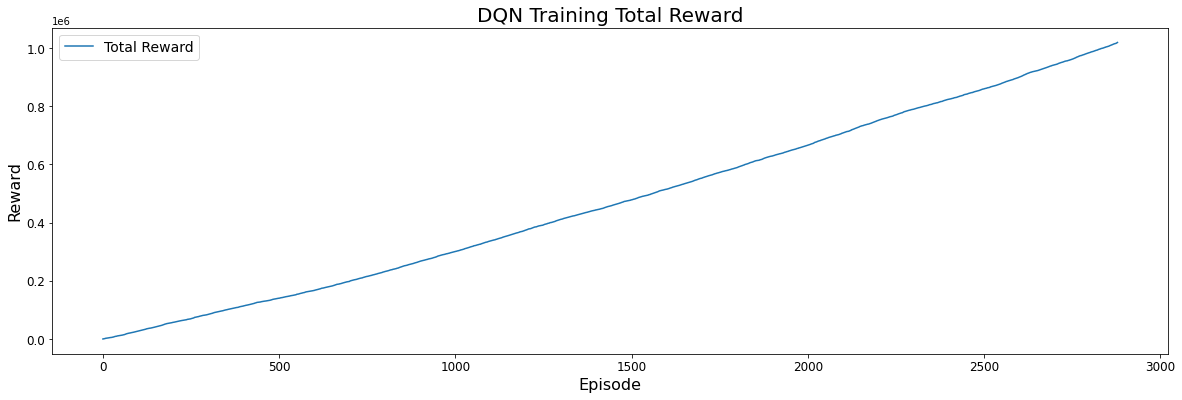

In [15]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, col='Total Reward', x_label='Episode', y_label='Reward', title='DQN Training Total Reward')

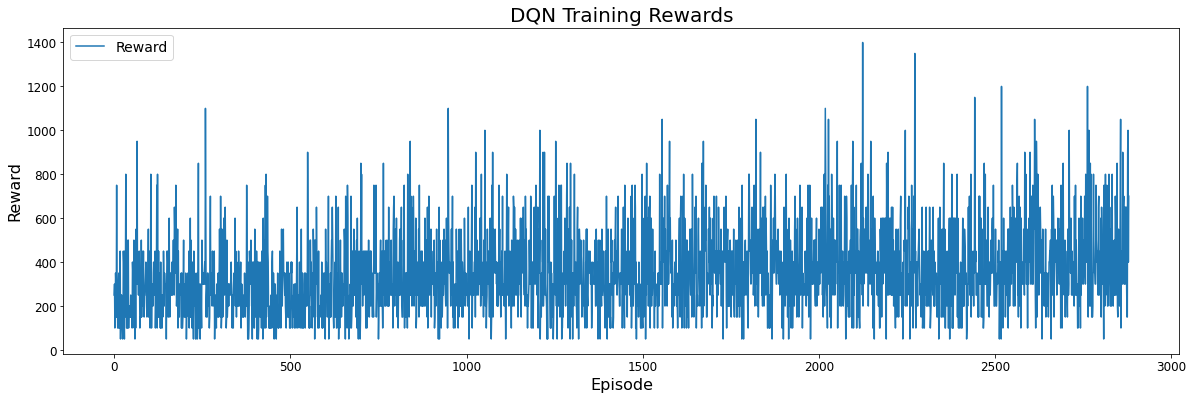

In [16]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, col='Reward', x_label='Episode', y_label='Reward', title='DQN Training Rewards')

In [17]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('sumtree_ddqn_data.csv')

In [18]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
online_model = agent.online
online_model.save('trained_ddqn_online_model.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
target_model = agent.target
target_model.save('trained_ddqn_target_model.h5')  